In [ ]:
!pip install langchain langgraph langchain-community langchain-text-splitters langchain-groq langchain-huggingface langchain-chroma sentence-transformers

In [ ]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
llm.invoke("Which Model are you?")

AIMessage(content='I’m ChatGPT, built on OpenAI’s GPT‑4 architecture.', additional_kwargs={'reasoning_content': 'The user asks "Which Model are you?" They want to know which model. According to policy, we can disclose that we are GPT-4. The system says we are ChatGPT, a large language model trained by OpenAI. So answer: I\'m based on GPT-4 architecture.'}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 76, 'total_tokens': 159, 'completion_time': 0.174545469, 'prompt_time': 0.003096971, 'queue_time': 0.185674526, 'total_time': 0.17764244}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--765d2699-f804-4eab-b315-014120f7876a-0', usage_metadata={'input_tokens': 76, 'output_tokens': 83, 'total_tokens': 159})

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

docs = []
for url in urls:
    try:
        loader = WebBaseLoader(url)
        docs.extend(loader.load())
    except Exception as e:
        print(f"Error loading {url}: {e}")

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs)

In [ ]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embeddings,
    persist_directory="./chroma_db"
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

In [ ]:
import os
from pydantic import BaseModel, Field

In [ ]:
class RetrieveDecision(BaseModel):
    """Decides whether to retrieve documents for the query."""
    decision: str = Field(description="Decision to retrieve: 'yes' or 'no'")
    reasoning: str = Field(description="Explanation for the decision")

class RelevanceGrade(BaseModel):
    """Grades document relevance to the question."""
    relevance: str = Field(description="Document relevance: 'relevant' or 'irrelevant'")

class SupportGrade(BaseModel):
    """Grades whether generation is supported by documents."""
    support: str = Field(description="Support level: 'supported', 'partial', or 'unsupported'")

class UsefulnessGrade(BaseModel):
    """Grades usefulness of response to question."""
    usefulness: int = Field(description="Usefulness score from 1-5")

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    retrieve_decision: str
    relevant_docs: List[str]
    support_grade: str
    usefulness_score: int
    regeneration_count: int

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# 1. Retrieve Decision Chain
retrieve_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert assistant that decides whether external information retrieval is needed.
    Analyze the question and determine if it requires external knowledge beyond general understanding.

    Consider:
    - Is this a factual question requiring specific information?
    - Can this be answered with general knowledge?
    - Does this need recent or specialized information?

    Respond with 'yes' if retrieval is needed, 'no' if general knowledge is sufficient."""),
    ("human", "Question: {question}")
])
retrieve_chain = retrieve_prompt | llm.with_structured_output(RetrieveDecision)

In [ ]:
# 2. Relevance Grader Chain
relevance_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a document relevance grader. Assess if the retrieved document contains
    information relevant to answering the user's question. Grade as 'relevant' or 'irrelevant'."""),
    ("human", "Question: {question}\n\nDocument: {document}")
])
relevance_chain = relevance_prompt | llm.with_structured_output(RelevanceGrade)

In [ ]:
# 3. Support Grader Chain
support_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a factual support grader. Determine if the generated answer is supported.

    For answers based on retrieved documents: Grade how well the documents support the answer.
    For general knowledge answers: Grade as 'supported' if the answer is factually correct.

    Grade as:
    - 'supported': Answer is well-supported or factually correct
    - 'partial': Some support but could be better
    - 'unsupported': Poor support or factually incorrect"""),
    ("human", "Context: {context}\n\nQuestion: {question}\n\nGeneration: {generation}")
])
support_chain = support_prompt | llm.with_structured_output(SupportGrade)

In [ ]:
# 4. Usefulness Grader Chain
usefulness_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a response usefulness grader. Rate how well the generation answers
    the user's question on a scale of 1-5:
    - 5: Completely answers the question with comprehensive detail
    - 4: Mostly answers the question well
    - 3: Adequately answers the question
    - 2: Partially addresses the question
    - 1: Does not answer the question

    Be generous with scoring for simple factual questions that are answered correctly."""),
    ("human", "Question: {question}\n\nGeneration: {generation}")
])
usefulness_chain = usefulness_prompt | llm.with_structured_output(UsefulnessGrade)

In [ ]:
from langchain_core.output_parsers import StrOutputParser
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful AI assistant. Use the provided context documents to answer
    the user's question accurately and comprehensively. If the context doesn't contain enough
    information, say so clearly. Cite specific information from the context when possible."""),
    ("human", "Context: {context}\n\nQuestion: {question}")
])

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = rag_prompt | llm | StrOutputParser()

In [ ]:
def decide_retrieve(state):
    """Node: Decide whether to retrieve documents using reflection token."""
    print("🤔 DECIDING WHETHER TO RETRIEVE...")

    question = state["question"]
    decision = retrieve_chain.invoke({"question": question})

    print(f"Decision: {decision.decision}")
    print(f"Reasoning: {decision.reasoning}")

    return {
        "question": question,
        "retrieve_decision": decision.decision,
        "documents": [],
        "generation": "",
        "relevant_docs": [],
        "support_grade": "",
        "usefulness_score": 0,
        "regeneration_count": 0  # Initialize counter
    }

In [ ]:
def retrieve_documents(state):
    """Node: Retrieve documents from vector store."""
    print("🔍 RETRIEVING DOCUMENTS...")

    question = state["question"]
    documents = retriever.invoke(question)

    print(f"Retrieved {len(documents)} documents")
    return {**state, "documents": documents}

In [ ]:
def grade_documents(state):
    """Node: Grade document relevance using ISREL token."""
    print("📋 GRADING DOCUMENT RELEVANCE...")

    question = state["question"]
    documents = state["documents"]

    relevant_docs = []
    for doc in documents:
        grade = relevance_chain.invoke({
            "question": question,
            "document": doc.page_content
        })

        if grade.relevance == "relevant":
            relevant_docs.append(doc)
            print(f"✅ Document relevant")
        else:
            print(f"❌ Document not relevant")

    print(f"Relevant documents: {len(relevant_docs)}/{len(documents)}")
    return {**state, "relevant_docs": relevant_docs}

In [ ]:
def generate_answer(state):
    """Node: Generate answer using relevant documents."""
    print("✍️ GENERATING ANSWER...")

    question = state["question"]
    relevant_docs = state["relevant_docs"]

    if not relevant_docs:
        generation = "I don't have enough relevant information to answer this question accurately."
    else:
        context = "\n\n".join([doc.page_content for doc in relevant_docs])
        rag_prompt = ChatPromptTemplate.from_messages([
            ("system", "Use the provided context to answer the question accurately and comprehensively."),
            ("human", "Context: {context}\n\nQuestion: {question}")
        ])
        rag_chain = rag_prompt | llm | StrOutputParser()
        generation = rag_chain.invoke({"context": context, "question": question})

    print("Generation completed")
    return {**state, "generation": generation}

In [ ]:
def grade_generation(state):
    """Node: Grade generation using ISSUP and ISUSE tokens."""
    print("🎯 GRADING GENERATION QUALITY...")

    question = state["question"]
    generation = state["generation"]
    relevant_docs = state["relevant_docs"]

    # Prepare context for grading
    if relevant_docs:
        context = f"Retrieved documents: {len(relevant_docs)} documents"
    else:
        context = "General knowledge answer (no retrieved documents)"

    # Support grading
    support_result = support_chain.invoke({
        "context": context,
        "question": question,
        "generation": generation
    })
    support_grade = support_result.support

    # Usefulness grading
    usefulness_result = usefulness_chain.invoke({
        "question": question,
        "generation": generation
    })
    usefulness_score = usefulness_result.usefulness

    print(f"Support: {support_grade}")
    print(f"Usefulness: {usefulness_score}/5")

    return {
        **state,
        "support_grade": support_grade,
        "usefulness_score": usefulness_score
    }

In [ ]:
def direct_answer(state):
    """Node: Answer directly without retrieval."""
    print("💭 ANSWERING WITHOUT RETRIEVAL...")

    question = state["question"]
    direct_prompt = ChatPromptTemplate.from_messages([
        ("system", "Answer the question using your general knowledge. Be accurate and concise."),
        ("human", "{question}")
    ])

    direct_chain = direct_prompt | llm | StrOutputParser()
    generation = direct_chain.invoke({"question": question})

    return {
        **state,
        "generation": generation,
        "support_grade": "supported",  # Assume general knowledge is supported
        "usefulness_score": 4,  # Give reasonable score for direct answers
        "regeneration_count": 0
    }

In [ ]:
def regenerate_answer(state):
    """Node: Regenerate answer with improved prompt."""
    print("🔄 REGENERATING ANSWER...")

    question = state["question"]
    relevant_docs = state["relevant_docs"]
    regeneration_count = state.get("regeneration_count", 0) + 1

    # Improved regeneration prompt
    regen_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert assistant. The previous answer was not satisfactory.
        Please provide a more comprehensive, accurate, and directly relevant answer.
        Focus on being clear, specific, and directly addressing the user's question."""),
        ("human", "Context: {context}\n\nQuestion: {question}\n\nAttempt: {attempt}")
    ])

    regen_chain = regen_prompt | llm | StrOutputParser()

    if relevant_docs:
        context = "\n\n".join([doc.page_content for doc in relevant_docs])
    else:
        context = "Use your general knowledge to provide an accurate answer."

    generation = regen_chain.invoke({
        "context": context,
        "question": question,
        "attempt": regeneration_count
    })

    print(f"Regeneration attempt: {regeneration_count}")
    return {
        **state,
        "generation": generation,
        "regeneration_count": regeneration_count
    }

In [ ]:
def should_retrieve(state):
    """Route based on retrieve decision token."""
    decision = state["retrieve_decision"]
    return "retrieve" if decision == "yes" else "direct_answer"

In [ ]:
def should_generate(state):
    """Route based on document relevance."""
    relevant_docs = state["relevant_docs"]
    return "generate" if len(relevant_docs) > 0 else "direct_answer"

In [ ]:
def is_answer_good(state):
    """Route based on generation quality tokens with regeneration limit."""
    support_grade = state["support_grade"]
    usefulness_score = state["usefulness_score"]
    regeneration_count = state.get("regeneration_count", 0)

    # CRITICAL FIX: Limit regeneration attempts to prevent infinite loops
    MAX_REGENERATIONS = 2

    if regeneration_count >= MAX_REGENERATIONS:
        print(f"🛑 Maximum regeneration attempts ({MAX_REGENERATIONS}) reached. Ending.")
        return "end"

    # Good answer criteria - MORE LENIENT
    is_supported = support_grade in ["supported", "partial"]
    is_useful = usefulness_score >= 3

    if is_supported and is_useful:
        print("✅ Answer meets quality criteria. Ending.")
        return "end"
    else:
        print(f"❌ Answer needs improvement (Support: {support_grade}, Usefulness: {usefulness_score})")
        return "regenerate"

In [ ]:
from langgraph.graph import END, StateGraph, START
# Build the FIXED Self-RAG Graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("decide_retrieve", decide_retrieve)
workflow.add_node("retrieve_documents", retrieve_documents)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("grade_generation", grade_generation)
workflow.add_node("direct_answer", direct_answer)
workflow.add_node("regenerate_answer", regenerate_answer)

# Add edges
workflow.add_edge(START, "decide_retrieve")

workflow.add_conditional_edges(
    "decide_retrieve",
    should_retrieve,
    {
        "retrieve": "retrieve_documents",
        "direct_answer": "direct_answer"
    }
)

workflow.add_edge("retrieve_documents", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    should_generate,
    {
        "generate": "generate_answer",
        "direct_answer": "direct_answer"
    }
)

workflow.add_edge("generate_answer", "grade_generation")
workflow.add_edge("direct_answer", "grade_generation")

workflow.add_conditional_edges(
    "grade_generation",
    is_answer_good,
    {
        "end": END,
        "regenerate": "regenerate_answer"
    }
)

workflow.add_edge("regenerate_answer", "grade_generation")

# Compile the graph
app = workflow.compile()

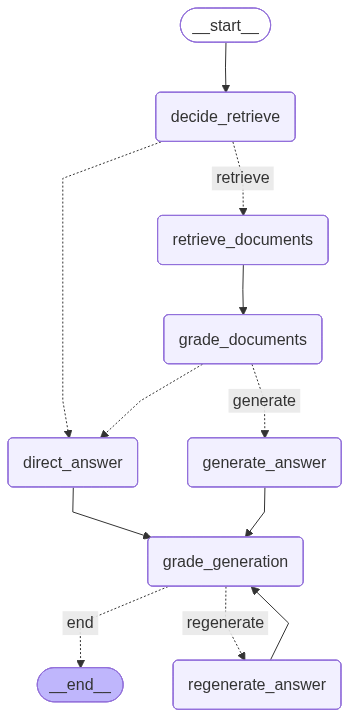

In [ ]:
app

In [ ]:
def run_self_rag(question: str):
    """Run the Self-RAG system with a question."""
    print(f"🚀 STARTING SELF-RAG FOR: {question}")
    print("=" * 60)

    inputs = {"question": question}

    final_state = None
    for step, output in enumerate(app.stream(inputs), 1):
        for node_name, node_output in output.items():
            print(f"Step {step} - Node: {node_name}")
            final_state = node_output
        print("-" * 40)

    print("\n🎉 FINAL RESULTS:")
    print(f"Question: {final_state['question']}")
    print(f"Answer: {final_state['generation']}")
    print(f"Support Grade: {final_state['support_grade']}")
    print(f"Usefulness Score: {final_state['usefulness_score']}/5")
    print("=" * 60)

    return final_state

In [ ]:
test_questions = [
    "What is the capital of France?",  # Should use direct answer
    "Explain how agent memory works in AI systems?",  # Should retrieve documents
    "What are the latest developments in prompt engineering?"  # Should retrieve documents
]

for question in test_questions:
    result = run_self_rag(question)
    print("\n\n")

🚀 STARTING SELF-RAG FOR: What is the capital of France?
🤔 DECIDING WHETHER TO RETRIEVE...
Decision: no
Reasoning: The capital of France is a well-known fact that can be answered from general knowledge without external retrieval.
Step 1 - Node: decide_retrieve
----------------------------------------
💭 ANSWERING WITHOUT RETRIEVAL...
Step 2 - Node: direct_answer
----------------------------------------
🎯 GRADING GENERATION QUALITY...
Support: supported
Usefulness: 5/5
✅ Answer meets quality criteria. Ending.
Step 3 - Node: grade_generation
----------------------------------------

🎉 FINAL RESULTS:
Question: What is the capital of France?
Answer: The capital of France is **Paris**.
Support Grade: supported
Usefulness Score: 5/5



🚀 STARTING SELF-RAG FOR: Explain how agent memory works in AI systems?
🤔 DECIDING WHETHER TO RETRIEVE...
Decision: no
Reasoning: The question asks for a conceptual explanation of agent memory in AI systems, which can be answered using general knowledge without n